In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

In [7]:
env = gym.make('MountainCar-v0')
env.goal_position = 0
#MountainCar-v0
#CartPole-v1
env.seed(1); torch.manual_seed(1);

In [3]:
#Hyperparameters
learning_rate = 0.01
gamma = 0.99

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.l2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy and reward history
        self.episode_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
#             nn.Dropout(p=0.8),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [5]:
def predict(state):
    # Select an action (0 or 1) by running policy model
    # and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    action_probs = policy(state)
    distribution = Categorical(action_probs)
    action = distribution.sample()

    # Add log probability of our chosen action to our history
    policy.episode_actions = torch.cat([
        policy.episode_actions,
        distribution.log_prob(action).reshape(1)
    ])

    return action

In [6]:
def update_policy():
    R = 0
    rewards = []

    # Discount future rewards back to the present using gamma
    for r in policy.episode_rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / \
        (rewards.std() + np.finfo(np.float32).eps)

    # Calculate loss
    loss = (torch.sum(torch.mul(policy.episode_actions, rewards).mul(-1), -1))

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()

In [19]:
def train(episodes):
    scores = []
    max_positions = []
    for episode in range(episodes):
        # Reset environment and record the starting state
        state = env.reset()
        max_pos = state[0]

        for time in range(450):
            if episode % 500 < 1:
                env.render()
            action = predict(state)

            # Uncomment to render the visual state in a window
            # env.render()

            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.item())
            
            if state[0] > max_pos:
                reward += 2
                max_pos = state[0]

            # Save reward
            policy.episode_rewards.append(reward)
            
            if state[0] > env.goal_position:
                break

        update_policy()

        # Calculate score to determine when the environment has been solved
        scores.append(time)
        max_positions.append(max_pos)

        if episode % 100 == 0:
            mean_score = np.mean(scores[-100:])
            max_position = np.max(max_positions[-100:])
            print('Episode {}\tAverage length (last 100 episodes): {:.2f}'.format(
                episode, mean_score))
            print('Episode {}\tmax pos (last 100 episodes): {:.2f}'.format(
                episode, max_position))

#         if mean_score > env.spec.reward_threshold:
#             print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
#                   .format(episode, mean_score, time))
#             break

In [20]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
train(episodes=10001)

Episode 0	Average length (last 100 episodes): 449.00
Episode 0	max pos (last 100 episodes): -0.33
Episode 100	Average length (last 100 episodes): 448.27
Episode 100	max pos (last 100 episodes): 0.01
Episode 200	Average length (last 100 episodes): 449.00
Episode 200	max pos (last 100 episodes): -0.07
Episode 300	Average length (last 100 episodes): 449.00
Episode 300	max pos (last 100 episodes): -0.03
Episode 400	Average length (last 100 episodes): 449.00
Episode 400	max pos (last 100 episodes): -0.03
Episode 500	Average length (last 100 episodes): 447.14
Episode 500	max pos (last 100 episodes): 0.00
Episode 600	Average length (last 100 episodes): 437.36
Episode 600	max pos (last 100 episodes): 0.01
Episode 700	Average length (last 100 episodes): 433.84
Episode 700	max pos (last 100 episodes): 0.02
Episode 800	Average length (last 100 episodes): 449.00
Episode 800	max pos (last 100 episodes): -0.00
Episode 900	Average length (last 100 episodes): 449.00
Episode 900	max pos (last 100 episo

Episode 8000	Average length (last 100 episodes): 126.18
Episode 8000	max pos (last 100 episodes): 0.05
Episode 8100	Average length (last 100 episodes): 153.61
Episode 8100	max pos (last 100 episodes): 0.04
Episode 8200	Average length (last 100 episodes): 151.19
Episode 8200	max pos (last 100 episodes): 0.04
Episode 8300	Average length (last 100 episodes): 123.60
Episode 8300	max pos (last 100 episodes): 0.04
Episode 8400	Average length (last 100 episodes): 136.70
Episode 8400	max pos (last 100 episodes): 0.04
Episode 8500	Average length (last 100 episodes): 136.51
Episode 8500	max pos (last 100 episodes): 0.04
Episode 8600	Average length (last 100 episodes): 172.35
Episode 8600	max pos (last 100 episodes): 0.03
Episode 8700	Average length (last 100 episodes): 158.60
Episode 8700	max pos (last 100 episodes): 0.04
Episode 8800	Average length (last 100 episodes): 190.73
Episode 8800	max pos (last 100 episodes): 0.04
Episode 8900	Average length (last 100 episodes): 172.00
Episode 8900	max 

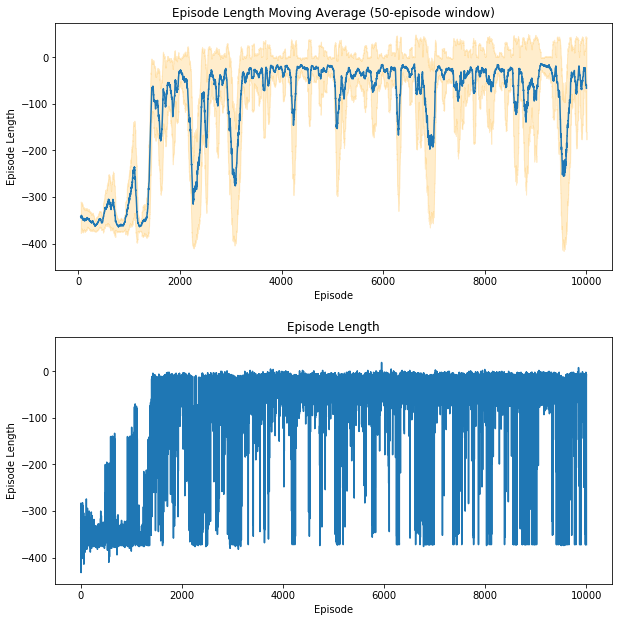

In [21]:
# number of episodes for rolling average
window = 50

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()